

   ## Modeling- binary classification
- This notebook will focus on building models that predict the binarized poverty level of households
- Along with training the model, there are a few processing steps that I will include in a sklearn pipeline 

In this notebook, I will binarize the outcome variable: 
- 1 = extreme poverty; 2 = moderate poverty ==> 1: high poverty
- 3 = vulnerable households; 4 = non vulnerable households ==> 0: low poverty

The positive class is also the minority class. As a rule of thumb, you should prefer AUPRC whenever the positive class is rare, or when you care more about the false positives than the false negatives. Otherwise, use AUROC.    

- **As a rule of thumb, you should prefer the precision recall (PR) curve whenever the positive class is rare (say I want to predict whether a number is 5 (positive case) or not 5 (negative case), and only 10% of the sample are actually 5), or when you care more about the false positives than the false negatives, and the ROC curve (FP does not appear!) otherwise.** 


In [1]:
'''data'''
import pandas as pd
import numpy as np
import itertools
from itertools import compress


'''common'''
from pathlib import Path
from collections import OrderedDict
import pickle


'''sklearn'''
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score, cross_val_predict, train_test_split,
    cross_validate,
    RandomizedSearchCV,GridSearchCV,
    learning_curve)

from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


'''feature engine'''
from feature_engine.selection import DropConstantFeatures
from feature_engine.imputation import MeanMedianImputer

'''models'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier


'''metrics'''
from sklearn.metrics import (
    confusion_matrix,
    precision_score, recall_score, f1_score, 
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score
)

'''visualization'''
import seaborn as sns
import matplotlib.pyplot as plt

'''warnings'''
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings("ignore", category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

## Config

In [2]:
# Scoring method for models
SCORING = "f1_weighted" #"f1_macro", "average_precision" 
# Random seed
RANDOM_STATE = 10

## Custom estimator

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

# This custom step saves the column names of its input dataframe as a .pkl file
class save_col_names(BaseEstimator, TransformerMixin):
    """
    Constructor

    Args:
        void

    Returns:
        void
    """

    def __init__(self, step_name:str):
        self.step_name = step_name # step_name is the name of the step prior to "save_col_names"


    def fit(self, X,
            y=None):  # need to have y as argument to make class compatible with sklearn pipeline
        """ Fit

        Args:
            X (DataFrame): a input dataframe of features to train the transformer
            y (DataFrame): a input Series of response variable to train the transformer (optional)

        Returns:
            self
        """

        return self

    def transform(self, X):
        """ Transform

        Args:
            X (DataFrame): a input dataframe of features to be transformed

        """

        # Make a copy of the input dataframe
        # so we won't overwrite the original Dataframe that was passed as argument
        X = X.copy()
        
        # Get feature names
        feature_names = X.columns.tolist
        
        # Save as pickle
        with open(Path('data','outputs',f'{self.step_name}_feature_names.pkl'), 'wb') as f:
            pickle.dump(feature_names, f)

        return X

## Import
- Load the interim data 

In [4]:
file_path = Path("data","interim", "interim.pkl")
df = pd.read_pickle(file_path)

In [5]:
df.head()

,Id,idhogar,Target,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,...,escolari_normalized_by_age-sum,escolari_normalized_by_age-std,escolari_normalized_by_age-range_,inst_normalized_by_age-max,inst_normalized_by_age-std,inst_normalized_by_age-range_,tech-min,tech-sum,tech-std,tech-range_
0,ID_279628684,21eb7fcc1,4.0,0,0,1,1,1,0,0,...,0.232558,NaN,0.000000,0.069767,NaN,0.000000,1,1,NaN,0
1,ID_f29eb3ddd,0e5d7a658,4.0,0,0,1,1,0,0,0,...,0.179104,NaN,0.000000,0.104478,NaN,0.000000,2,2,NaN,0
2,ID_68de51c94,2c7317ea8,4.0,0,0,1,1,0,0,0,...,0.119565,NaN,0.000000,0.043478,NaN,0.000000,0,0,NaN,0
3,ID_ec05b1a7b,2b58d945f,4.0,0,0,1,1,1,0,0,...,1.366183,0.126943,0.279412,0.176471,0.033010,0.071207,2,8,0.0,0
4,ID_1284f8aad,d6dae86b7,4.0,1,0,1,1,1,0,0,...,0.965584,0.168946,0.392857,0.142857,0.060063,0.142857,1,4,0.0,0


In [6]:
# Get feature names
train_feature_names = df.columns.tolist()
# Remove Target and the Id columns
train_feature_names = [v for v in train_feature_names if v not in ["Target", "Id","idhogar"]]

In [7]:
# For this notebook, we will binarize the target variable
df["bin_target"] = np.where(df["Target"]<=2, 1, 0)

In [8]:
poverty_mapping = OrderedDict({0: 'low poverty', 1: 'high poverty'})

**Currently, the interim set contains both the train and test (hold-out) set. Separate them out.**

In [9]:
# Rows in the interim dataframe that has non-null values for the Target column are from the train dataset
X_train = df.loc[df["Target"].notnull(), train_feature_names]
y_train = df.loc[df["Target"].notnull(),"bin_target"]

In [10]:
# rows in the interim dataframe that has null values for the Target column are from the test (holdout) dataset
X_test  = df.loc[df["Target"].isnull(), train_feature_names]

**Note that the unit of analysis for the interim dataframe is household, as we will only be fitting a model to make predictions at the household level. There are 2973 households in X_train.**

In [11]:
X_train.shape, y_train.shape, X_test.shape

((2973, 219), (2973,), (7334, 219))

In [12]:
# Make a copy of the household_id for the households in the test set
test_ids = list(df.loc[df['Target'].isnull(), 'idhogar'])

In [13]:
len(test_ids)

7334

## Extent of missingness
- Despite imputing some of the "ignorable" cases in the previous notebook, there are still some missing values in the X_train and X_test. In this section, we will investigate and impute the remaining missing values.
- There is no missing value in y_train.

In [14]:
def extent_missinginess(df):
    return (df
         .isnull()
         .mean()
         .mul(100)
         .reset_index(name="percentage")
         .sort_values(by="percentage", ascending=False))

In [15]:
train_missing = extent_missinginess(X_train)
train_missing.head(10)

,index,percentage
213,inst_normalized_by_age-std,13.084427
210,escolari_normalized_by_age-std,13.084427
114,estadocivil2-std,13.050790
134,parentesco2-std,13.050790
128,estadocivil7-std,13.050790
99,v18q-std,13.050790
202,age-std,13.050790
190,mobilephone-std,13.050790
131,parentesco1-std,13.050790
205,inst-std,13.050790


**At most I have 13% values missing in the train and test sets. Since the proportion of missingness is relatively small, I will impute with median.**

**I will drop features that have near zero variance as they will not be useful in predicting the outcome.**

**I also want to use MaxMinScaler to normalize all features as some models that we want to try might be scale variant.**

## Data pipeline

In [16]:
# Create pipeline
data_pipeline = Pipeline([
 
     # === Imputation === #
     ("missing_imputation", MeanMedianImputer(imputation_method="median")),
 
     # === drop qusai-constant variables === #
     # drop variables with any level that appears in 0.75 of observations
     ('drop_nzv', DropConstantFeatures(tol=0.75)),
    
    # === save feature names (of the df from the drop_nzv step) ===
    ('save_feature_names', save_col_names(step_name='drop_nzv')),
 
     # === normalization === #
     ('scaler', MinMaxScaler()), 
 ])

**NOTE: the output of pipeline with sklearn steps is a ndarray. It is only if the pipeline contains exclusively feature-engine steps will its output be a dataframe.**

In [17]:
# Fit and transform X_train
x_tr_processed = data_pipeline.fit_transform(X_train) 

In [18]:
# Get saved feature names
with open(Path('data','outputs','drop_nzv_feature_names.pkl'), 'rb') as f:
    list_ = pickle.load(f)
    
saved_feature_names=list_()

# Convert ndarray (output of data pipeline) to a dataframe with the saved feature names
x_tr_processed = pd.DataFrame(x_tr_processed, columns = saved_feature_names)

In [19]:
# Transform X_test
x_tst_processed= data_pipeline.transform(X_test)
x_tst_processed = pd.DataFrame(x_tst_processed, columns = saved_feature_names)

## Save processed data

In [20]:
x_tr_processed.to_pickle(Path("data","processed","x_tr_processed.pkl"))
x_tst_processed.to_pickle(Path("data","processed","x_tst_processed.pkl"))

y_train.to_pickle(Path("data","processed","y_tr_processed.pkl"))

## Feature Selection using a model (aka embedded method)
- Feature selection is performed using "Embedded methods" (regularized logisitic regression) that concurrently performs feature selection and model training.
- Use SelectFromModel(): SelectFromModel is a meta-transformer that can be used alongside any estimator that assigns importance to each feature through a specific attribute (such as coef_, feature_importances) or via an importance_getter callable after fitting.
- Features are considered unimportant and removed (set to False in the output selector.get_support()) if the corresponding importance of the feature values are below the provided threshold parameter. Apart from specifying the threshold numerically, there are built-in heuristics for finding a threshold using a string argument. Available heuristics are “mean”, “median” and float multiples of these like “0.1*mean”. In combination with the threshold criteria, one can use the max_features parameter to set a limit on the number of features to select.

### Implementation
- As a first pass, let's perform feature selection on the processed data
- In a real-life data project, we should include this as a step in a data pipeline (which we will do later in this notebook)
- Use SelectFromModel*( wrapper which requires a model for feature selection
- I will use sklearn's LogisticRegression:
    - L2 (Ridge) regularization is applied by default
    - sklearn automatically detects the multiclass case and the training algorithm will default to use the one-vs-rest (OvR) scheme. I can also set the multi-class parameters to specify what scheme I want to use to deal with multicalss. sklearn will use cross-entropy loss if the ‘multi_class’ option is set to ‘multinomial’. 

In [21]:
# Model for feature selection
sel_clf = LogisticRegression(penalty = 'l2',
                C=0.1, # inverse of regularization strength, smaller values means stronger regularization
                random_state=RANDOM_STATE)

In [22]:
# Init the selector
selector = SelectFromModel(estimator=sel_clf,
                          threshold="1.25*mean") # only keep feature whose coeff is above 1.25* mean(coeff) 

In [23]:
# Fit the selector with the processed train dataset
selector=selector.fit(x_tr_processed,y_train)

In [24]:
# Look at the features that were selected (those that were assigned True)
selector.get_support() # mask

array([ True, False, False,  True, False, False, False, False,  True,
       False,  True,  True, False, False, False, False,  True, False,
       False, False,  True,  True, False, False,  True,  True, False,
        True, False,  True,  True, False, False,  True,  True, False,
       False, False,  True, False, False,  True, False,  True, False,
       False, False, False, False, False, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False,  True,  True,  True, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False])

In [25]:
print(f"In total, {selector.get_support().sum()} features out of the original {len(x_tr_processed.columns)} are selected.")

In total, 27 features out of the original 91 are selected.


In [26]:
# Print the list of selected features
selected_feats = x_tr_processed.columns[selector.get_support()]
selected_feats

Index(['paredblolad', 'energcocinar2', 'area1', 'dependency', 'edjefe', 'r4h2',
       'r4t1', 'r4t2', 'hogar_nin', 'hogar_adul', 'qmobilephone', 'roof',
       'floor', 'amenities', 'phones_per_capita', 'female-sum',
       'estadocivil1-sum', 'estadocivil3-std', 'instlevel1-sum',
       'instlevel2-sum', 'instlevel8-max', 'escolari-min', 'escolari-max',
       'escolari-sum', 'inst-max', 'inst_normalized_by_age-range_',
       'tech-min'],
      dtype='object')

**We can include SelectFromModel as a step in the data pipeline. The transform function of SelectFromModel will extract only the selected columns from the input dataframe.**

## Modelling

- y_train is highly imbalanced: 22% of observations has high poverty (extremely, or moderately vulnerable), and 77% low poverty (no or low vulnerability).
- **Test harness:** to ensure each of our folds has the same class distribution as the full train data, we need to use StratifiedKFold, or StratifiedShuffleSplit

In [27]:
y_train.value_counts(normalize=True)

0    0.776657
1    0.223343
Name: bin_target, dtype: float64

In [28]:
# Init the feature selector (repeat the steps above)

# Model for feature selection
sel_clf = LogisticRegression(penalty = 'l2',
                # inverse of regularization strength, smaller values means stronger regularization, 
                # could be a tuneable parameter later in GridSearchCV
                C=0.1, 
                #multi_class = 'ovr', # one vs rest
                random_state=RANDOM_STATE)

In [29]:
# Define function to compute cv_scores for a user-specified model
def evaluate_model(X,y,clf,cv,scoring):
    
    # Create pipeline
    data_pipeline = Pipeline([
 
         # === Imputation === #
         ("missing_imputation", MeanMedianImputer(imputation_method="median")),
 
         # === drop qusai-constant variables === #
         # drop variables with a level that appears in 0.75 of observations
         ('drop_nzv', DropConstantFeatures(tol=0.75)),
 
         # === normalization === #
         ('scaler', MinMaxScaler()),
        
        # === feature selection using logreg === #
        ("feature_selection", SelectFromModel(estimator=sel_clf, threshold="1.25*mean")),
        
         # === model === #
         ('model', clf)
     ])
    
    # Compute cv scores
    cv_scores = cross_val_score(estimator = data_pipeline,
                                X = X,
                                y = y,
                                scoring = scoring,
                                cv = cv,
                                n_jobs=1)
    
    return cv_scores

In [30]:
# Define the CV iterator
skf = StratifiedKFold(
    n_splits = 10,
    shuffle = True,
    random_state = RANDOM_STATE
)
skf.get_n_splits()

10

In [31]:
# Define a dict of models
models = {"dummy": DummyClassifier(),
          "SGD" : SGDClassifier(),
          "Random Forest": RandomForestClassifier(n_estimators= 1000),
          "Extra trees": ExtraTreesClassifier(),
          "SVC" : LinearSVC(),
          "Naive Bayes": GaussianNB(),
          "KNN": KNeighborsClassifier()
         }

In [32]:
warnings.filterwarnings('ignore', category = ConvergenceWarning)

# Train each model in the models dict, and then populate a dataframe with scores

res = {} # empty results dictionary that will contain cv_scores for each model

for k,v in models.items():
    cv_scores = evaluate_model(X = X_train,
                   y = y_train,
                   clf = v,
                   cv = skf,
                   scoring = SCORING
                  )
    # update results dictionary
    res.update({k:cv_scores})
    
    # print mean and sd cv scores of each model\
    print(f"{k}")
    print(f"mean {SCORING}: {np.round(np.mean(cv_scores),2)}")
    print(f"stdev {SCORING}: {np.round(np.std(cv_scores),2)}")
    print()

dummy
mean f1_weighted: 0.68
stdev f1_weighted: 0.0

SGD
mean f1_weighted: 0.77
stdev f1_weighted: 0.02

Random Forest
mean f1_weighted: 0.78
stdev f1_weighted: 0.02

Extra trees
mean f1_weighted: 0.76
stdev f1_weighted: 0.02

SVC
mean f1_weighted: 0.78
stdev f1_weighted: 0.02

Naive Bayes
mean f1_weighted: 0.75
stdev f1_weighted: 0.01



/Users/hfung/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:230: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/hfung/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:230: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None 

KNN
mean f1_weighted: 0.75
stdev f1_weighted: 0.02



/Users/hfung/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:230: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [33]:
res

{'dummy': array([0.67698963, 0.67698963, 0.67698963, 0.68055556, 0.68055556,
        0.68055556, 0.68055556, 0.68055556, 0.68055556, 0.67595627]),
 'SGD': array([0.76125238, 0.77307925, 0.78323124, 0.77511478, 0.77064533,
        0.79849976, 0.73188406, 0.7775309 , 0.78792572, 0.78711356]),
 'Random Forest': array([0.75255312, 0.7753018 , 0.7856194 , 0.79611777, 0.75904827,
        0.75421245, 0.79698709, 0.80695272, 0.79611777, 0.77980428]),
 'Extra trees': array([0.73838253, 0.76886103, 0.77354222, 0.75384717, 0.75163437,
        0.74422047, 0.78400488, 0.78870387, 0.77589071, 0.76752745]),
 'SVC': array([0.76125238, 0.79622022, 0.76342331, 0.77858542, 0.74936676,
        0.77266194, 0.77250214, 0.7753096 , 0.79012346, 0.80475353]),
 'Naive Bayes': array([0.75059434, 0.74961875, 0.74224259, 0.75835373, 0.74580067,
        0.74121408, 0.73556617, 0.74541063, 0.76358758, 0.75999569]),
 'KNN': array([0.71739508, 0.77156166, 0.76369067, 0.75698345, 0.76199466,
        0.72445579, 0.74676

In [34]:
# Create results dataframe
df_res = pd.DataFrame.from_dict(res)
df_res.head()

,dummy,SGD,Random Forest,Extra trees,SVC,Naive Bayes,KNN
0,0.676990,0.761252,0.752553,0.738383,0.761252,0.750594,0.717395
1,0.676990,0.773079,0.775302,0.768861,0.796220,0.749619,0.771562
2,0.676990,0.783231,0.785619,0.773542,0.763423,0.742243,0.763691
3,0.680556,0.775115,0.796118,0.753847,0.778585,0.758354,0.756983
4,0.680556,0.770645,0.759048,0.751634,0.749367,0.745801,0.761995


## Visualize cv scores

In [35]:
df_res.unstack().to_frame()

0
dummy 0  0.676990
      1  0.676990
      2  0.676990
      3  0.680556
      4  0.680556
...           ...
KNN   5  0.724456
      6  0.746764
      7  0.773205
      8  0.757013
      9  0.760481

[70 rows x 1 columns]

Text(0.5, 0, 'CV average f1_weighted')

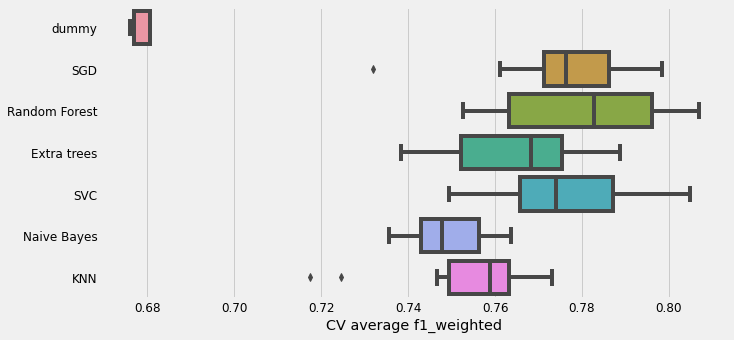

In [36]:
# Plot styling
plt.style.use("fivethirtyeight")
plt.rcParams["font.size"] = 12

df_res = df_res.unstack().to_frame()

fig = plt.figure(figsize=(10,5))
sns.boxplot(
    y=df_res.index.get_level_values(0),
    x=df_res[0])
plt.xlabel(f"CV average {SCORING}")

## Hyperparameters tuning using RandomizedSearchCV
- I will select RandomForestClassifer as the model to optimize
- I will tune parameters for the processing transformers also (e.g., SelectModel)

In [37]:
# Define the CV iterator
skf = StratifiedKFold(
    n_splits = 5,
    shuffle = True,
    random_state = 10
)
skf.get_n_splits()

5

In [38]:
# Create pipeline
data_pipeline = Pipeline([
    # === Imputation === #
    ("missing_imputation", MeanMedianImputer(imputation_method="median")),
    
    # === drop qusai-constant variables === #
    # drop variables with a level that appears in tol of observations
    ('drop_nzv', DropConstantFeatures()),
    
    # === normalization === #
    ('scaler', MinMaxScaler()),
    
    # === feature selection using logreg === #
    ("fs", SelectFromModel(estimator=sel_clf)),
    
    # === model === #
    ('clf',  RandomForestClassifier())
 ])

In [39]:
# random grid
random_grid = {
    
    # drop_nzv parameterse
    "drop_nzv__tol":[0.75, 0.8, 0.9],
    
    # feature selection parameters
    "fs__threshold":["mean","1.25*mean", "1.5*mean"],
    
    # classifier parameters 
    "clf__n_estimators": [10, 100, 1000],
    "clf__max_depth": [None,1,3,10,40,50],
    "clf__min_samples_split": [2,5,10,50,100],
    "clf__min_samples_leaf": [2,5,10,50,100]
}

In [40]:
# Perform random search of the parameters, using a 10 fold CV to estimate the test metric for each setting.

# init random grid search object
rand_grid_search = RandomizedSearchCV(estimator = data_pipeline,
                                param_distributions = random_grid,
                                n_iter = 10,  # randomly select 10 different settings to try
                                cv = skf,       # use 5-fold CV for each setting to estimate its test metric
                                scoring=SCORING,
                                verbose = 1, #2   # show the process
                                n_jobs =-1,  # use all processors
                                random_state = RANDOM_STATE)

In [41]:
# fit model
rand_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
                   estimator=Pipeline(steps=[('missing_imputation',
                                              MeanMedianImputer()),
                                             ('drop_nzv',
                                              DropConstantFeatures()),
                                             ('scaler', MinMaxScaler()),
                                             ('fs',
                                              SelectFromModel(estimator=LogisticRegression(C=0.1,
                                                                                           random_state=10))),
                                             ('clf',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'clf__max_depth': [None, 1, 3, 10, 40,
                                                           50],
                  

In [42]:
print(f"The mean CV {SCORING} of the best estimator is: {rand_grid_search.best_score_}")

The mean CV f1_weighted of the best estimator is: 0.7821034899780663


In [43]:
# Optimized parameters
rand_grid_search.best_params_ 

{'fs__threshold': 'mean',
 'drop_nzv__tol': 0.8,
 'clf__n_estimators': 100,
 'clf__min_samples_split': 10,
 'clf__min_samples_leaf': 2,
 'clf__max_depth': 50}

## Hyperparameters tuning using GridSearchCV
- Hone in on a smaller set of hyperparameters to tune (fine tuning)

In [44]:
# Create pipeline, setting some parameters based on Random Search results
data_pipeline = Pipeline([
    # === Imputation === #
    ("missing_imputation", MeanMedianImputer(imputation_method="median")),
    
    # === drop qusai-constant variables === #
    # drop variables with a level that appears in tol of observations
    ('drop_nzv', DropConstantFeatures(tol=0.8)),
    
    # === normalization === #
    ('scaler', MinMaxScaler()),
    
    # === feature selection using logreg === #
    ("fs", SelectFromModel(estimator=sel_clf)),
    
    # === model === #
    ('clf',  RandomForestClassifier(n_estimators=100))
 ])

In [45]:
# parameter grid
param_grid = {
     
    # feature selection parameters
    "fs__threshold":["0.5*mean","0.75*mean","mean"],
    
    # classifier parameters 
    "clf__max_depth": [40, 50, 60],
    "clf__min_samples_split": [8,10,15],
    "clf__min_samples_leaf": [1,2,3]
}

In [46]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = data_pipeline, 
                           param_grid = param_grid, 
                           cv = skf, 
                           scoring=SCORING,
                           verbose =1, # show the process
                           n_jobs = -1)  # n_jobs = -1 means use all processors

In [47]:
# fit model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=Pipeline(steps=[('missing_imputation',
                                        MeanMedianImputer()),
                                       ('drop_nzv',
                                        DropConstantFeatures(tol=0.8)),
                                       ('scaler', MinMaxScaler()),
                                       ('fs',
                                        SelectFromModel(estimator=LogisticRegression(C=0.1,
                                                                                     random_state=10))),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [40, 50, 60],
                         'clf__min_samples_leaf': [1, 2, 3],
                         'clf__min_samples_split': [8, 10, 15],
                         'fs__threshold': ['0.5*mean', '0.75*mean', 'mean']},
      

In [48]:
# Let's take a look at the optimal parameters
grid_search.best_params_

{'clf__max_depth': 40,
 'clf__min_samples_leaf': 3,
 'clf__min_samples_split': 10,
 'fs__threshold': '0.75*mean'}

In [49]:
# What is the score of the model with the optimal parameter
print(f"The optimal model has {SCORING} of {grid_search.best_score_}")

The optimal model has f1_weighted of 0.794439583106374


In [50]:
# Persist the optimal pipeline (NOTE: the estimator of the grid_search object is a pipeline)
grid_search_best_pipeline = grid_search.best_estimator_

# Save as pickle
with open(Path('models','grid_search_best_pipeline.pkl'), 'wb') as f:
    pickle.dump(grid_search_best_pipeline, f)

## Selected features

In [51]:
# Original number of columns in X_train
len(train_feature_names)

219

In [52]:
# features dropped due to nzv
dropped_features = grid_search_best_pipeline.named_steps.drop_nzv.features_to_drop_
len(dropped_features)

117

In [53]:
# features that remain after dropping those with nzv
feature_names_post_nzv= [f for f in X_train.columns.values if f not in dropped_features]
len(feature_names_post_nzv)

102

In [54]:
# Get the boolean mask of features that are selected by SelectFrom Model
mask = (grid_search_best_pipeline.named_steps.fs.get_support())
len(mask)

102

In [55]:
# Get list of features that are selected
selected_features=list(compress(feature_names_post_nzv, mask))
len(selected_features)

59

## Feature importance from Random Forest

In [56]:
# Get best random forest model
best_rf= grid_search_best_pipeline.named_steps["clf"]

In [57]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': selected_features, 
                                'importance': best_rf.feature_importances_})
feature_results.head()

,feature,importance
0,paredblolad,0.019170
1,pisomoscer,0.015528
2,sanitario3,0.003886
3,energcocinar2,0.007339
4,energcocinar3,0.006105


<AxesSubplot:title={'center':'Top 10 important features from random forest'}, xlabel='Features', ylabel='Normalized feature importance'>

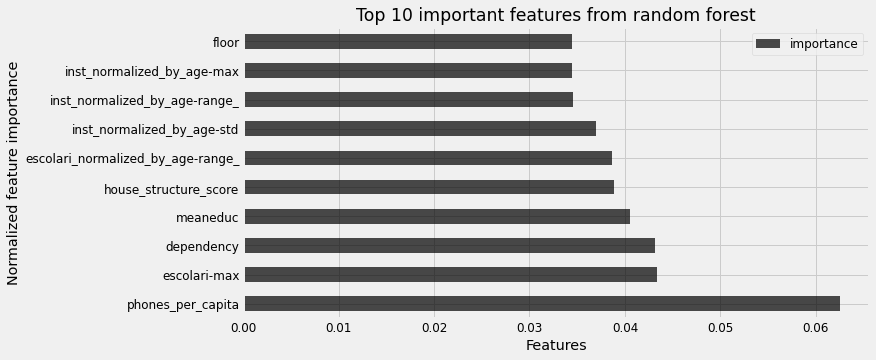

In [58]:
# Bar plot
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

(feature_results
     .sort_values("importance", ascending=False)
     .set_index("feature")
     .head(10)
     .plot.barh(
         ax=ax,
         color='k',
         alpha=0.7,
         title="Top 10 important features from random forest",
         ylabel="Normalized feature importance",
         xlabel="Features"         
     ))

## Assess model predictions
- We selected a ML approach
- We optimized it by tuning its hyperparameters using RandomizedSearch CV and GridSearchCV
- We persisted the optimized data pipeline
- Now, let's look at different evaluation metrics

### Label distribution of the train data compared to that of the prediction
- We would expect the distribution of the labels from the train data, and the predictions inferred from the test data  to have similar distributions.
- The following histrograms are normalized, meaning that they show the relative frequency instead of the absolute counts. This is necessary because the raw counts differ in the training and testing data.

RECALL: When predicting, we only make one prediction for each household and then we merge the predictions dataframe on the household id (idhogar) with another dataframe with two columns: individual ID and household ID. Basically, I make the same prediction for everyone within a household.

Make predictions using the optimized pipeline

In [59]:
# Call predict on the estimator with the best found parameters. This is same as doing 
# grid_search_best_pipeline.predict(X_test)
preds = grid_search.predict(X_test)

In [60]:
len(preds) # these predictions are at the household level (one prediction per household)

7334

In [61]:
y_train.shape # these are the label of the train data, also at the household leve

(2973,)

Plot the histogram: counts are normalized to form a probability density, i.e., the area (or integral) under the histogram will sum to 1.

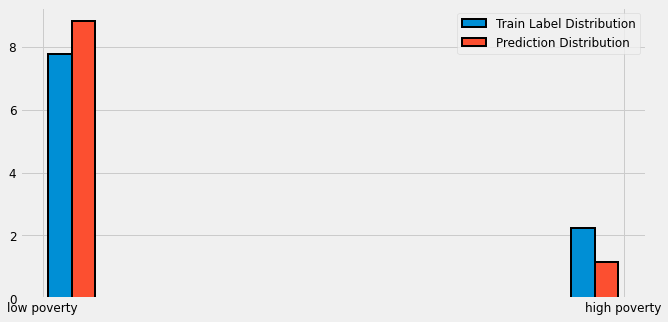

In [62]:
fig = plt.figure(figsize=(10,5))


# labels of the train set
plt.hist([y_train.to_numpy(),preds],
         label = ["Train Label Distribution", "Prediction Distribution"],
         density=True,
         edgecolor = 'k',
         linewidth = 2)


plt.xticks([0,1],poverty_mapping.values())
plt.legend(loc='best')

- We see that the prediction over-represents low poverty (the majortiy class), and under-represents high poverty (the minority class). Two methods to handle this:
- **Cost sensitive learning:** One solution is to include "weights" in ML models so that more emphasis will be given to the minority class (set class_weight parameter in RandomForestClassifier() to "balanced").
- **Data augomentation:** another solution is to use data-augmentation methods like SMOTE to augment the number of observations in the minority class.
- Both Cost sensitive learning and SMOTE will be implemented in a different notebook.

### Confusion Matrix
Method 1:
- Create train and validation set
- Train model on the train set
- Test model with the validation set: assess with the confusion matrix

Method 2:
- Use the FULL train set (don't split it into train and validation set)
- Performs K-fold CV (e.g., split FULL train set into 3 folds). Use 1 fold to test, and the remaining folds to train.
- If I use corss_val_predict(), each "test" fold is used generate "clean predictions". Meaning that the predictions were generated from a model that never saw the test data during training.
- I repeat this for all test folds to get a set clean predictions (has the same sample size as the FULL train set).

We will use Method 2

In [63]:
grid_search_best_pipeline # optimal pipeline

Pipeline(steps=[('missing_imputation', MeanMedianImputer()),
                ('drop_nzv', DropConstantFeatures(tol=0.8)),
                ('scaler', MinMaxScaler()),
                ('fs',
                 SelectFromModel(estimator=LogisticRegression(C=0.1,
                                                              random_state=10),
                                 threshold='0.75*mean')),
                ('clf',
                 RandomForestClassifier(max_depth=40, min_samples_leaf=3,
                                        min_samples_split=10))])

In [64]:
y_train_pred = cross_val_predict(
    estimator = grid_search_best_pipeline, # an estimator could be a pipeline or model
    X = X_train,
    y = y_train,
    cv = skf
)

In [65]:
# I have a set of clean predictions in y_train_pred
y_train_pred.shape, y_train.shape 

((2973,), (2973,))

In [66]:
# Confusion matrix
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[2190,  119],
       [ 453,  211]])

**Plot the confusion in a heatmap**

In [67]:
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[2190  119]
 [ 453  211]]


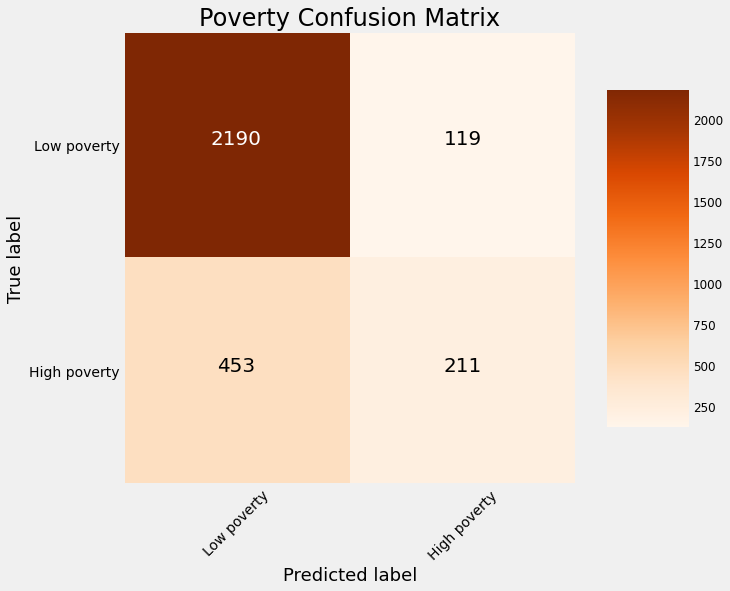

In [68]:
plot_confusion_matrix(cm = cm, 
                      classes = ['Low poverty', 'High poverty'],
                      normalize=False,
                      title = 'Poverty Confusion Matrix')

Normalized confusion matrix
[[0.94846254 0.05153746]
 [0.68222892 0.31777108]]


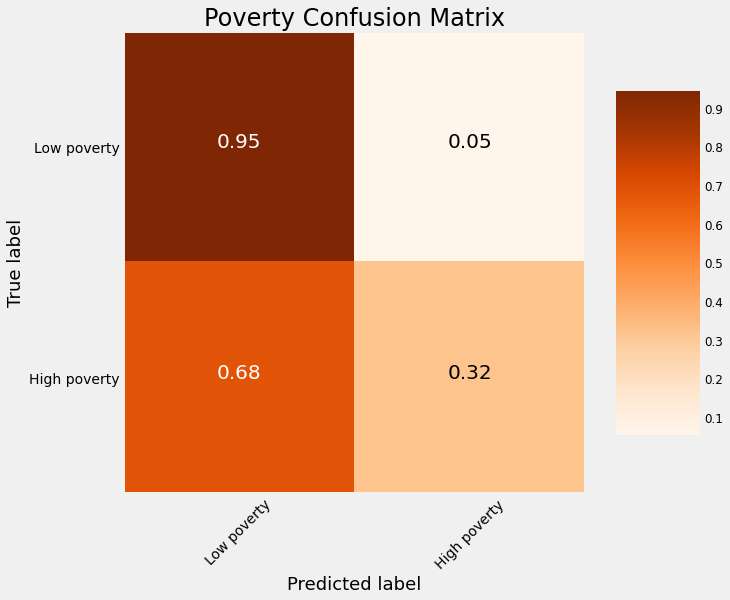

In [69]:
plot_confusion_matrix(cm = cm, 
                      classes = ['Low poverty', 'High poverty'],
                      normalize=True,
                      title = 'Poverty Confusion Matrix')

### Comments:
- Our model only predicts observations with low poverty (the majority calss) well. For example, it correctly predicts 95% of the observations in the validation set that actually have low poverty, and only 5% of those observations incorrectly as having high poverty.

- Since we are more interested in how well the model predicts high poverty level, we will look at the positive (and minority) class: 
    - The model only correctly predicts 0.32 of all observations that actually have high poverty. The model has 32% recall.
    - The model has moderately low precision. It makes 330 positive (high poverty) predictions, of those, 119 (64%) were correctly predicted. So it has 64% precision.

### ROC curve
- I use the optimized pipeline to compute the proba for each fold (y_scores)
- I use these proba scores to compute the fpr and tpr for each possible threshold.
- The results will be used to create ROC curve

In [70]:
y_train_pred_scores = cross_val_predict(
    estimator = grid_search_best_pipeline, # an estimator could be a pipeline or model
    X = X_train,
    y = y_train,
    cv = skf,
    method = "predict_proba"
)

In [71]:
y_train_pred_scores

array([[0.9299338 , 0.0700662 ],
       [0.90300139, 0.09699861],
       [0.67896402, 0.32103598],
       ...,
       [0.54732748, 0.45267252],
       [0.78999939, 0.21000061],
       [0.82802795, 0.17197205]])

In [72]:
y_train_pred_scores.shape

(2973, 2)

**Plotting the ROC curve**

In [73]:
y_train_pred_scores[:,1] # proba of the positive class

array([0.0700662 , 0.09699861, 0.32103598, ..., 0.45267252, 0.21000061,
       0.17197205])

In [74]:
fpr,tpr,thresholds = roc_curve(y_train, y_train_pred_scores[:,1])

In [75]:
def plot_roc_curve(fpr, tpr, label=None):
    
    plt.figure(figsize = (10, 8))
    plt.style.use("fivethirtyeight")
    plt.rcParams["font.size"] = 12
    
    plt.plot(fpr,tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--') # dashed diagonal
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (Recall)")

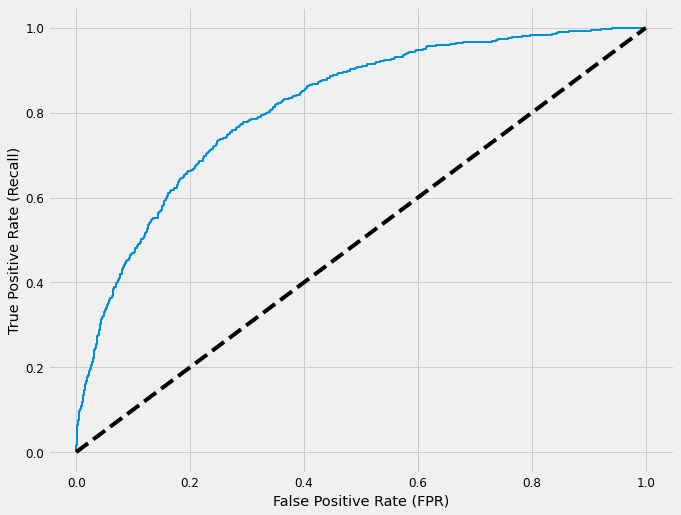

In [76]:
plot_roc_curve(fpr, tpr)

In [77]:
print(f"The roc_auc score is {roc_auc_score(y_train, y_train_pred_scores[:,1])}")

The roc_auc score is 0.814968405453777


NOTE: since our dataset has imbalanced class, ROC_AUC score tends to be an overestimation of the model performance.

### Precision and Recall curve
- As a rule of thumb, you should use AUPRC whenever the positive class is rare (as in our case) or when you care more about the false positives than the false negatives. Otherwise, we use AUROC.
- If I set my threshold to a high value, say 0.8, the classifier will make less positive predictions. In this case, its precision will increase, but its recall will decrease. The inverse is true if the threshold is low (e.g., 0.3).

In [78]:
# Compute the precision and recall for every possible threshold
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_pred_scores[:,1])

**Plot the precision recall curve**

In [79]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    
    plt.figure(figsize = (10, 8))
    plt.style.use("fivethirtyeight")
    plt.rcParams["font.size"] = 12
    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    
    plt.xlabel("Threshold")
    plt.ylabel("Metric")
    plt.title("Precision and Recall vs Threshold")
    plt.legend(loc="best")

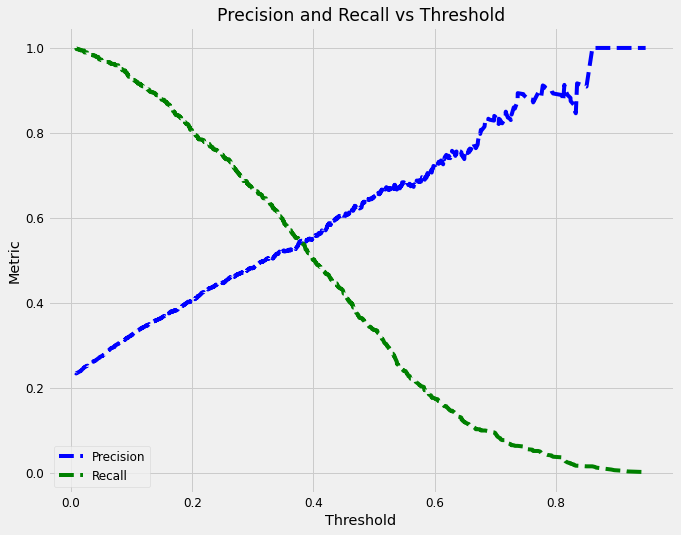

In [80]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [81]:
def plot_precision_vs_recall(precisions, recalls):
    
    plt.figure(figsize = (10, 8))
    plt.style.use("fivethirtyeight")
    plt.rcParams["font.size"] = 12
    
    plt.plot(recalls[:-1], precisions[:-1])
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision vs Recall")

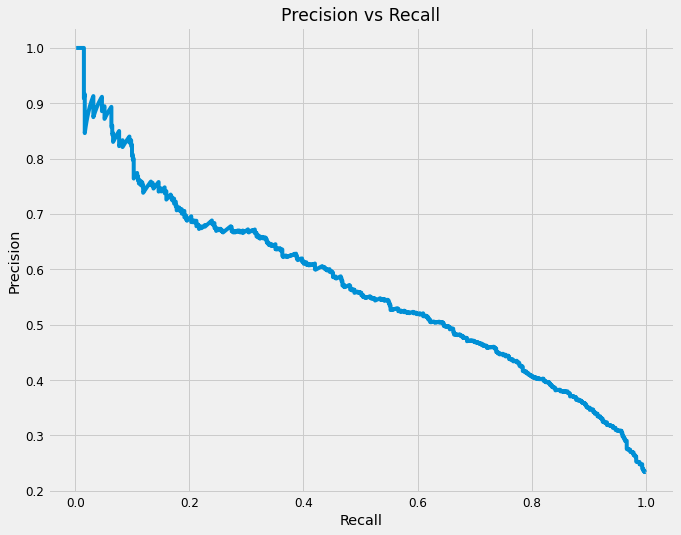

In [82]:
plot_precision_vs_recall(precisions, recalls)

**Compute the area under the precision recall curve (AUPRC)**
- Recall that if AUROC = 0.5, that means the performance of the classifier is no better than random guessing.
- The same is NOT true for AUPRC. The baseline value (lowest) for AUPRC is the proportion of positive outcomes in the sample:
    - positive outcomes/total # of samples
    - For us, that's around 0.22

In [83]:
y_train.value_counts(normalize=True)

0    0.776657
1    0.223343
Name: bin_target, dtype: float64

In [84]:
auprc = average_precision_score(y_train, y_train_pred_scores[:,1])

In [85]:
print(f"The area under the precision-recall curve (AUPRC) is {auprc}. The baseline value (random guessing) is 0.22.")

The area under the precision-recall curve (AUPRC) is 0.5692502258835752. The baseline value (random guessing) is 0.22.


### Learning Curves
- Purpose: check if my model is overfitting or underfitting the data.
- Estimate the train and test metric of the model using k-fold CV. The model will be trained data with varying sizes (starting at n=1, n=2, ...) 
- NOTE: the train metric is computed by training the model with the train set (remaining folds), and assessing using the same train set.
- At each iteration, I get different CV scores.
- Plot the CV scores against sample size to get learning curves.
- If the train metric is a lot higher than the test metric, then I am overfitting.
- If both the train metric and test metric are low, then I am underfitting.

In [86]:
train_sizes, train_scores, valid_scores = learning_curve(
    estimator = grid_search_best_pipeline, 
    X = X_train, 
    y = y_train,
    cv = skf,
    scoring = SCORING,
    train_sizes=[0.01,0.2,0.4,0.6,0.8,1.0]) # in proportion

In [87]:
train_sizes

array([  23,  475,  951, 1426, 1902, 2378])

In [88]:
train_scores

array([[0.8715415 , 0.8715415 , 0.80889788, 0.8715415 , 0.80889788],
       [0.90483086, 0.91700915, 0.90522614, 0.90829158, 0.92733938],
       [0.90286153, 0.91043333, 0.91264185, 0.91063122, 0.91186794],
       [0.91308848, 0.90313263, 0.916222  , 0.91430333, 0.9200304 ],
       [0.91777309, 0.9152574 , 0.92260168, 0.92606882, 0.91720413],
       [0.9171202 , 0.91203264, 0.91769418, 0.91458839, 0.9104326 ]])

In [89]:
valid_scores

array([[0.67876899, 0.67876899, 0.67876899, 0.68055556, 0.6782549 ],
       [0.73700394, 0.77749897, 0.74547588, 0.74683312, 0.77447893],
       [0.76417798, 0.78151096, 0.74321016, 0.76607579, 0.76475648],
       [0.77176471, 0.7706796 , 0.75583917, 0.76673164, 0.79029602],
       [0.77024619, 0.79875582, 0.75239067, 0.78707265, 0.78076559],
       [0.78696166, 0.79993663, 0.755312  , 0.79453927, 0.78579223]])

In [90]:
def plot_learning_curve(train_scores, valid_scores, train_sizes):
    plt.figure(figsize = (10, 8))
    plt.style.use("fivethirtyeight")
    plt.rcParams["font.size"] = 12
    

    plt.plot(train_sizes, train_scores.mean(axis=1), "r-", label="train")
    plt.plot(train_sizes, valid_scores.mean(axis=1), "b--", label="val")
    
    plt.xlabel("Training set size")
    plt.ylabel(f"{SCORING}")
    plt.title("Learning Curves")
    plt.legend(loc="best")

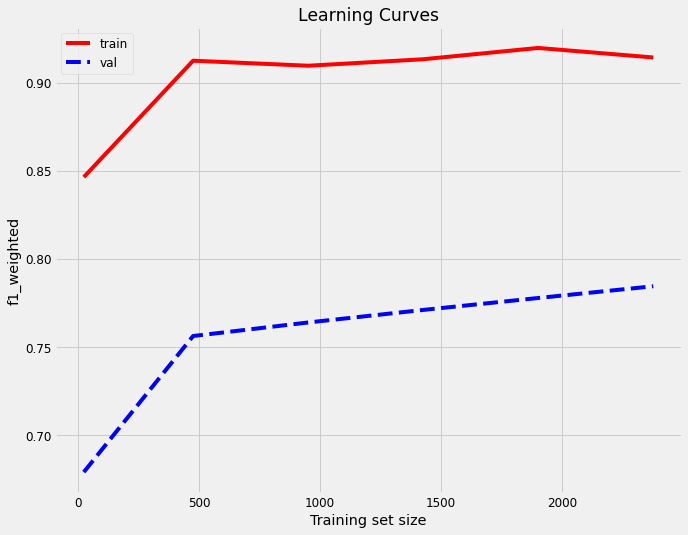

In [91]:
plot_learning_curve(train_scores, valid_scores, train_sizes)

**Comments** 
- My model seems to be overfitting as the validation f1 score is lower than the train f1 score by >0.10
- I need to:
    - increase sample size
    - reduce model complexity